### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [34]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
root_path = r'C:\EPGP\Deep Learning\CNN Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


- This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Use 80% of the images for training, and 20% for validation.

In [5]:
## training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=123,
            validation_split=0.2,
            subset="training",
            image_size=(img_height,img_width),
            batch_size=batch_size
)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


In [6]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
          data_dir_train,
          seed=123,
          validation_split=0.2,
          subset="validation",
          image_size=(img_height, img_width),
          batch_size=batch_size
)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


In [7]:
# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [8]:
# Listing out classes of all skin cancer types
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### visualizing one instance of all the nine classes present in the dataset

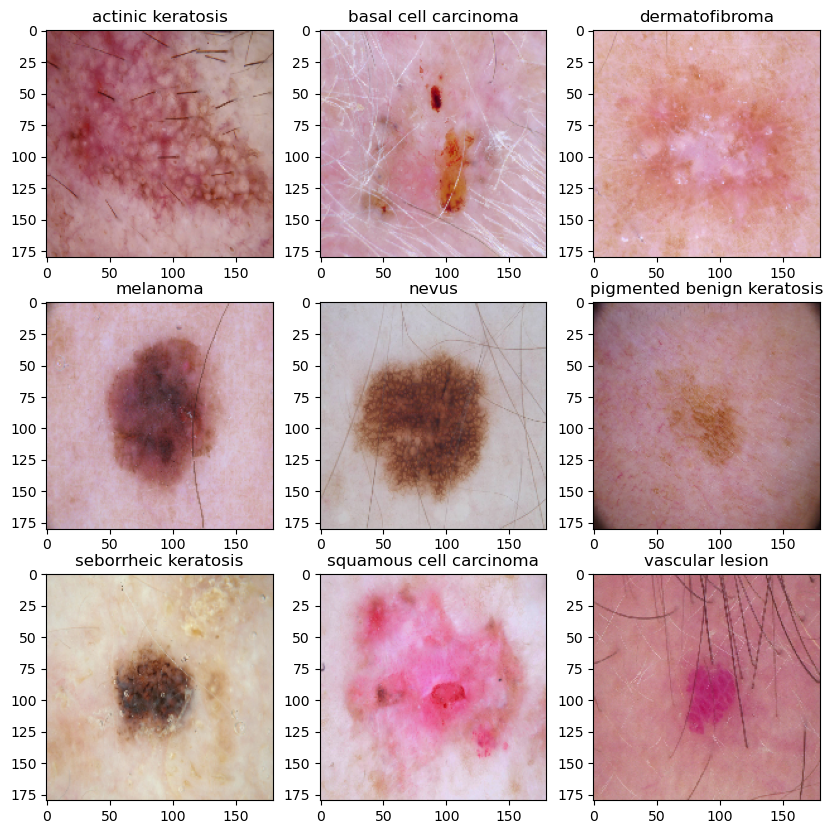

In [9]:
files_path_dict = {}

plt.figure(figsize=(10,10))
index = 0
for cs in class_names:
    files_path_dict[cs] = list(map(lambda x:str(data_dir_train)+'/'+cs+'/'+x, os.listdir(str(data_dir_train)+'/'+cs)))
    path_list = files_path_dict[cs][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height, img_width)))
    plt.title(cs)

    

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create a Model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
model = Sequential([
    # rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
     # maxpooling layer
  layers.MaxPooling2D(),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output dense layer
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
- Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
506/506 [==============================] - 273s 480ms/step - loss: 1.4482 - accuracy: 0.4553 - val_loss: 1.0312 - val_accuracy: 0.6336
Epoch 2/20
506/506 [==============================] - 231s 457ms/step - loss: 0.8799 - accuracy: 0.6854 - val_loss: 0.9643 - val_accuracy: 0.6689
Epoch 3/20
506/506 [==============================] - 227s 449ms/step - loss: 0.5618 - accuracy: 0.8029 - val_loss: 0.5635 - val_accuracy: 0.8031
Epoch 4/20
506/506 [==============================] - 227s 449ms/step - loss: 0.3809 - accuracy: 0.8636 - val_loss: 0.3553 - val_accuracy: 0.8913
Epoch 5/20
506/506 [==============================] - 233s 460ms/step - loss: 0.2900 - accuracy: 0.8977 - val_loss: 0.3223 - val_accuracy: 0.9029
Epoch 6/20
506/506 [==============================] - 229s 451ms/step - loss: 0.2334 - accuracy: 0.9168 - val_loss: 0.3077 - val_accuracy: 0.8967
Epoch 7/20
506/506 [==============================] - 239s 473ms/step - loss: 0.1972 - accuracy: 0.9268 - val_loss: 0.2913 -

### Visualizing training results

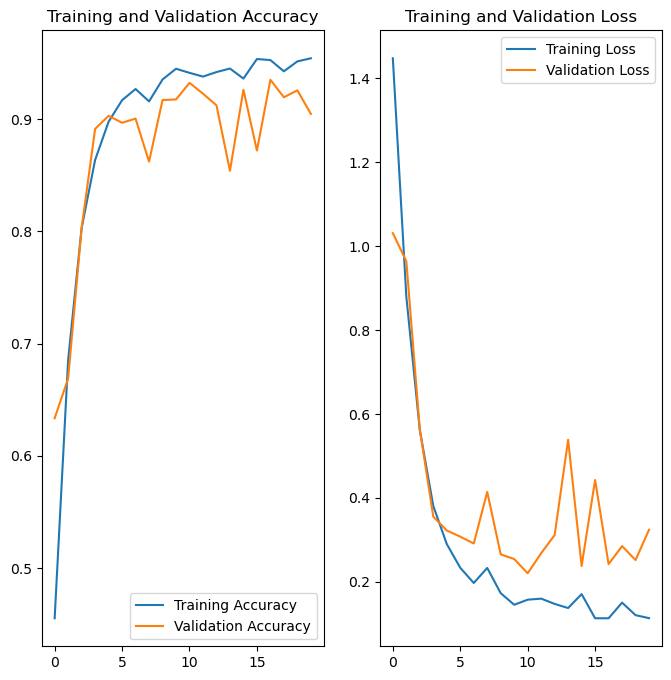

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- As we can see graph in between Training vs Validation accuracy as the epoch increases the difference between Training accuracy and validation accuracy increases. So we can say that Model is overfitting.

#### Here we will rescale input in the [0, 255] range to be in the [0, 1]. We will flip each image horizontally and vertically, rotate image and zoom during training.

In [17]:
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

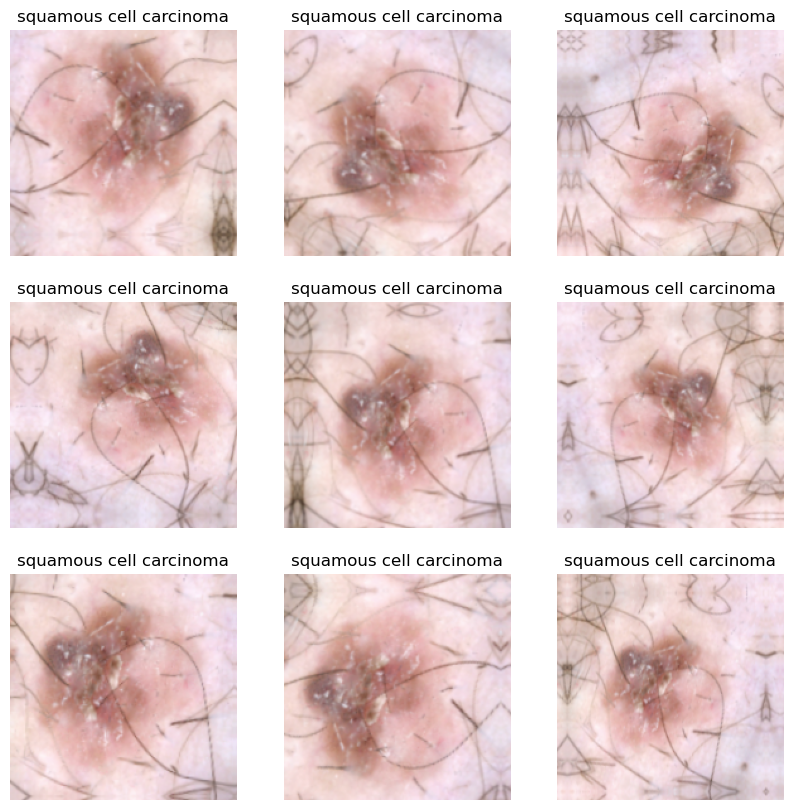

In [18]:
# visualize augmentated images for one instance of training image.
plt.figure(figsize=(10, 10))
for imgs, labels in train_ds.take(1):
    for i in range(num_classes):
        augmented_imgs = data_augmentation(imgs)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_imgs[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
plt.show()

#### We will use Dropout layer here now

In [19]:
model2 = Sequential()

model2.add(data_augmentation)
model2.add(rescale)
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.30))

model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Dropout(0.30))

model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(512,activation='relu'))

model2.add(layers.Dense(128,activation='relu'))

model2.add(layers.Dropout(0.45))

model2.add(layers.Dense(len(class_names),activation='softmax'))

#### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model for 20 epochs

In [21]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
506/506 [==============================] - 252s 494ms/step - loss: 0.1471 - accuracy: 0.9431 - val_loss: 0.2881 - val_accuracy: 0.9241
Epoch 2/20
506/506 [==============================] - 227s 448ms/step - loss: 0.1006 - accuracy: 0.9565 - val_loss: 0.2466 - val_accuracy: 0.9335
Epoch 3/20
506/506 [==============================] - 233s 461ms/step - loss: 0.1068 - accuracy: 0.9562 - val_loss: 0.3795 - val_accuracy: 0.8972
Epoch 4/20
506/506 [==============================] - 228s 451ms/step - loss: 0.1310 - accuracy: 0.9486 - val_loss: 0.2705 - val_accuracy: 0.9330
Epoch 5/20
506/506 [==============================] - 404s 799ms/step - loss: 0.0935 - accuracy: 0.9602 - val_loss: 0.2656 - val_accuracy: 0.9367
Epoch 6/20
506/506 [==============================] - 287s 567ms/step - loss: 0.1574 - accuracy: 0.9426 - val_loss: 0.3405 - val_accuracy: 0.9143
Epoch 7/20
506/506 [==============================] - 290s 572ms/step - loss: 0.0999 - accuracy: 0.9589 - val_loss: 0.3363 -

#### Visualizing the results

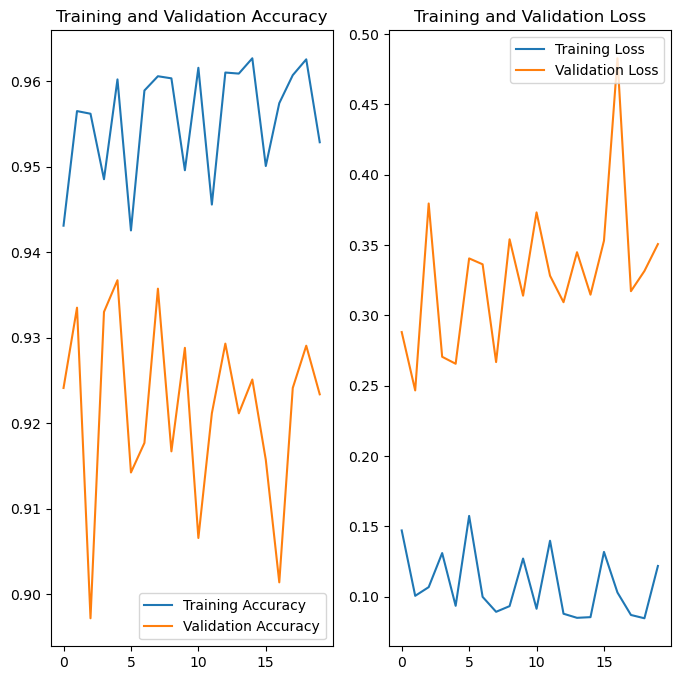

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Lets Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [53]:
def sample_count(dir):
    count= []
    for path in pathlib.Path(dir).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(dir)
                    if os.path.isdir(os.path.join(dir, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

class_df = sample_count(data_dir_train)
class_df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

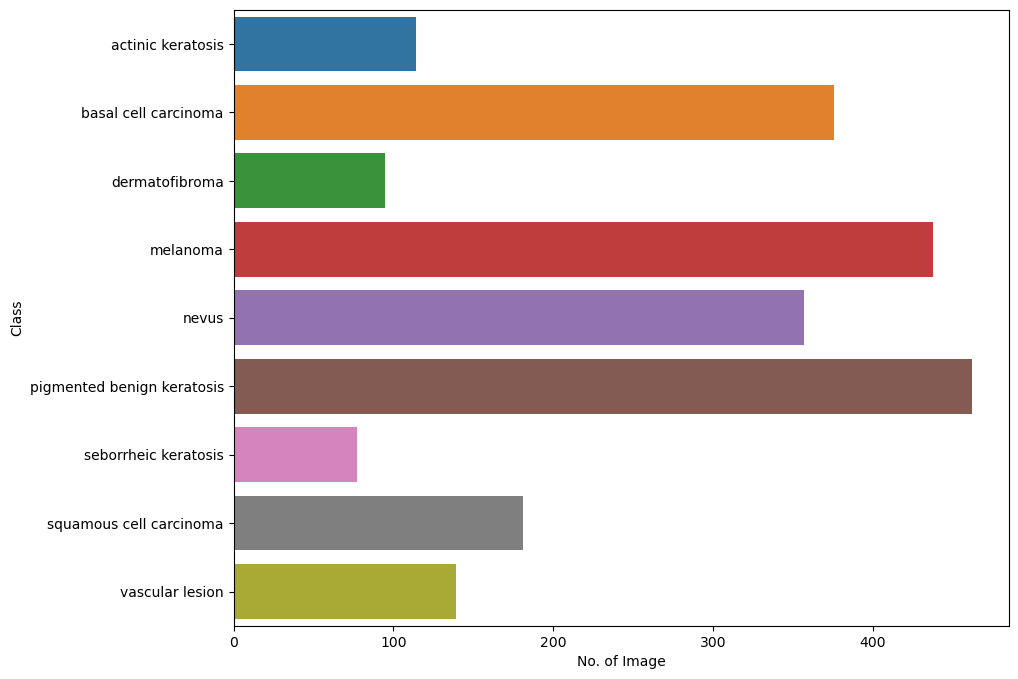

In [55]:
#Now Lets Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=class_df,
            label="Class")

- As we can see here that seborrheic keratosis has least number of samples
- melanoma class dominate the data in terms proportionate number of samples

In [23]:
import Augmentor

In [24]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [25]:
path_to_training_dataset=r"C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
for i in class_names:
    output_dir = os.path.join(path_to_training_dataset, i, "output")
    os.makedirs(output_dir, exist_ok=True)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F1FE64370>: 100%|█| 500/500 [00:03<00:00, 150.25 Samples


Initialised with 376 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F24270E20>: 100%|█| 500/500 [00:04<00:00, 100.76 Samples


Initialised with 95 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F1FE3C370>: 100%|█| 500/500 [00:05<00:00, 94.42 Samples/


Initialised with 438 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x20F1FE28D60>: 100%|█| 500/500 [00:56<00


Initialised with 357 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x20F08C13160>: 100%|█| 500/500 [00:22<00:00, 21.93 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20F1F683A90>: 100%|█| 500/500 [00:05<00:


Initialised with 77 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x20F08C318E0>: 100%|█| 500/500 [00:11<00


Initialised with 181 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F6E595D30>: 100%|█| 500/500 [00:05<00:00, 89.81 Samples/


Initialised with 139 image(s) found.
Output directory set to C:\\EPGP\\Deep Learning\\CNN Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F47146340>: 100%|█| 500/500 [00:06<00:00, 82.87 Samples/


In [26]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

22500


### Now lets build the Model

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    label_mode='categorical',
    seed=123,subset="training",
    validation_split=0.2
)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.


In [57]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    label_mode='categorical',
    seed=123,subset="validation",
    validation_split=0.2
)

Found 24739 files belonging to 9 classes.
Using 4947 files for validation.


In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
#CNN Model Architecture
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


In [45]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 41, 41, 128)      

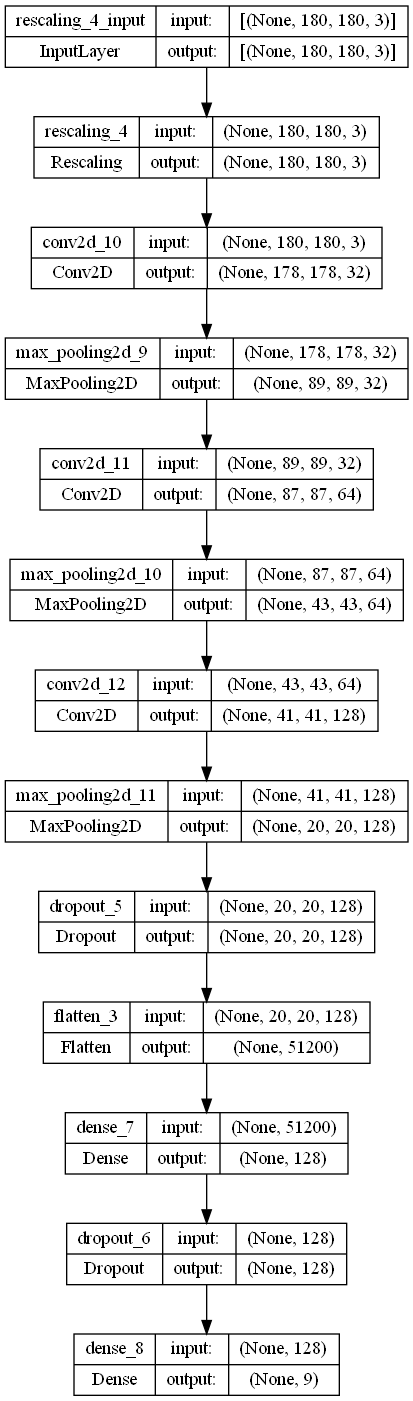

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Now compile the model

In [47]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",metrics=["accuracy"]
)

In [48]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,

checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#### Stop training when a monitored metric has stopped improving.

In [49]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [58]:
# Now Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint,earlystop]
)

Epoch 1/20
619/619 [==============================] - ETA: 0s - loss: 1.3125 - accuracy: 0.5019
Epoch 1: val_accuracy improved from -inf to 0.62947, saving model to model.h5
619/619 [==============================] - 589s 952ms/step - loss: 1.3125 - accuracy: 0.5019 - val_loss: 1.0630 - val_accuracy: 0.6295
Epoch 2/20
619/619 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.6446
Epoch 2: val_accuracy improved from 0.62947 to 0.73075, saving model to model.h5
619/619 [==============================] - 608s 981ms/step - loss: 0.9629 - accuracy: 0.6446 - val_loss: 0.7326 - val_accuracy: 0.7307
Epoch 3/20
619/619 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.7352
Epoch 3: val_accuracy improved from 0.73075 to 0.82575, saving model to model.h5
619/619 [==============================] - 565s 913ms/step - loss: 0.7239 - accuracy: 0.7352 - val_loss: 0.5064 - val_accuracy: 0.8258
Epoch 4/20
619/619 [==============================] - ETA: 0s - los

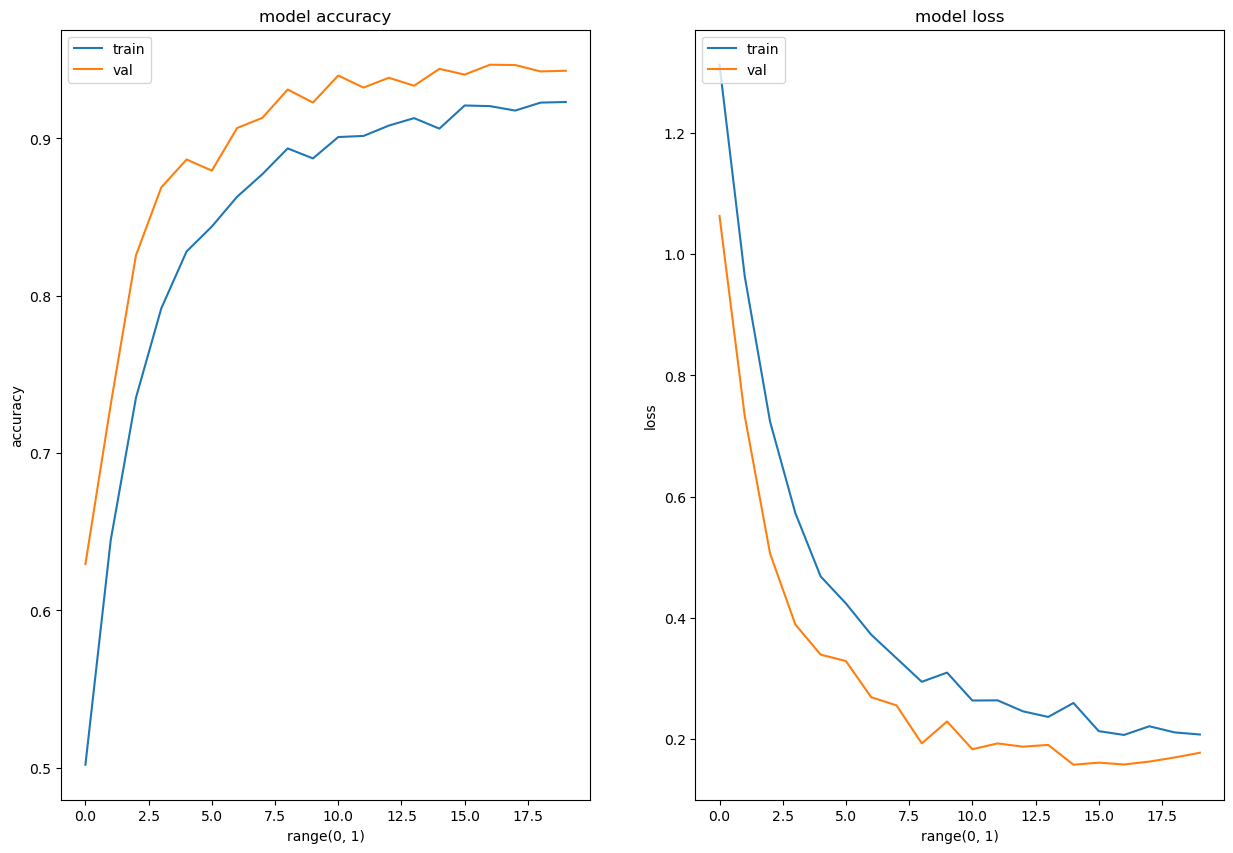

In [59]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Lets see Model Prediction

1/1 [==============================] - 1s 1s/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


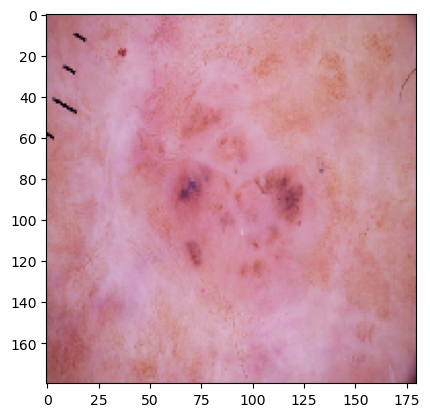

In [60]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )